## Evaluating the BiLSTM with Attention model on the dev set

### Dependency Management

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import os
import pickle
import nltk
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# Create a directory for NLTK data
nltk_data_dir = os.path.join(os.getcwd(), 'nltk_data')
os.makedirs(nltk_data_dir, exist_ok=True)

# Set the NLTK data path
nltk.data.path.append(nltk_data_dir)

# Download punkt to the specified directory
nltk.download('punkt_tab', download_dir=nltk_data_dir)

[nltk_data] Downloading package punkt_tab to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
from evidence_detection.bilstm_with_attention import BiLSTMAttention
from evidence_detection.vocabulary import Vocabulary
from evidence_detection.evidence_detection_dataset import EvidenceDetectionDataset

### Load dev set

In [6]:
dev_path = 'data/dev.csv'
dev_df = pd.read_csv(dev_path)

dev_df.head()

,Claim,Evidence,label
0,Democracy should be done away with.,"Amartya Sen, an Indian economist and Nobel lau...",0
1,Polygamy should be made legal.,The Supreme Court's unanimous decision in Reyn...,1
2,Hunting should be banned,In total it is estimated that Ceauşescu receiv...,0
3,Television should be given up.,Barbera mentioned that they had to either adju...,0
4,Abortions ought to be prohibited.,According to a poll conducted by Angus Reid St...,1


### Load the vocabulary and set the embedding dimension

The vocabulary "vocab.pkl" an be downloaded from the following link: https://drive.google.com/drive/folders/1TWv5UKNsNeQGxafx3GQf87Dc8vcp5V8t

In [7]:
# Load vocabulary
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [8]:
# Use the same embedding dimension used in training
embedding_dim = 300

### Create evaluation dataset and dataloader

In [9]:
def collate_fn(batch):
  """
  Custom collate function to handle variable-length sequences.

  Args:
    batch: A batch of data from the dataset

  Returns:
    Dictionary with padded sequences and other batch information
  """
  # Separate batch elements
  claims = [item['claim_ids'] for item in batch]
  claim_lengths = torch.tensor([item['claim_length'] for item in batch])
  evidences = [item['evidence_ids'] for item in batch]
  evidence_lengths = torch.tensor([item['evidence_length'] for item in batch])
  labels = torch.stack([item['label'] for item in batch])

  # Pad sequences
  padded_claims = pad_sequence(claims, batch_first=True, padding_value=0)
  padded_evidences = pad_sequence(evidences, batch_first=True, padding_value=0)

  return {
    'claim_ids': padded_claims,
    'claim_lengths': claim_lengths,
    'evidence_ids': padded_evidences,
    'evidence_lengths': evidence_lengths,
    'labels': labels
  }

In [10]:
# Create dataset
dev_dataset = EvidenceDetectionDataset(dev_df, vocab)

In [11]:
# Create evaluation data loader for evaluation
dev_loader = DataLoader(
    dev_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

### Load the model architecture and weights

The model weights "ED_model_B.pt" and architecture "model_architecture_parameters/parameters.pkl" can be downloaded from the following link:
https://drive.google.com/drive/folders/1TWv5UKNsNeQGxafx3GQf87Dc8vcp5V8t

In [12]:
model_path = "ED_model_B.pt"

# Load the best hyperparameters
with open('model_architecture_parameters/parameters.pkl', 'rb') as f:
    best_params = pickle.load(f)

print("Loaded hyperparameters:", best_params)
model = BiLSTMAttention(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    num_layers=1,
    hidden_dim=best_params['hidden_dim'],
    dropout=best_params['dropout'],
)

# Load the trained weights
model.load_state_dict(torch.load(model_path))
model.to(device)
print("\nModel loaded successfully.\n")
print(model)

Loaded hyperparameters: {'hidden_dim': 256, 'dropout': 0.4277148867646843, 'batch_size': 16, 'learning_rate': 0.00033550020021625327, 'weight_decay': 1.8390870324768507e-05}

Model loaded successfully.

BiLSTMAttention(
  (embedding): Embedding(12686, 300, padding_idx=0)
  (lstm_claim): LSTM(300, 128, batch_first=True, bidirectional=True)
  (lstm_evidence): LSTM(300, 128, batch_first=True, bidirectional=True)
  (attention_claim): AttentionLayer(
    (attention): Linear(in_features=256, out_features=1, bias=True)
  )
  (attention_evidence): AttentionLayer(
    (attention): Linear(in_features=256, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.4277148867646843, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4277148867646843, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)


### Run the model in inference mode

In [13]:
print("\nPerforming evaluation on dev.csv...\n")

# Set to evaluation mode
model.eval()

test_loss = 0.0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dev_loader, desc="Evaluating"):
        # Move batch to device
        claim_ids = batch['claim_ids'].to(device)
        claim_lengths = batch['claim_lengths']
        evidence_ids = batch['evidence_ids'].to(device)
        evidence_lengths = batch['evidence_lengths']
        labels = batch['labels'].to(device)

        # Forward pass
        logits, _ = model(claim_ids, claim_lengths, evidence_ids, evidence_lengths)
        loss = nn.CrossEntropyLoss()(logits, labels)

        # Accumulate metrics
        test_loss += loss.item()
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)

# Weighted
precision_weighted = precision_score(all_labels, all_predictions, average='weighted')
recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

# Macro
precision_macro = precision_score(all_labels, all_predictions, average='macro')
recall_macro = recall_score(all_labels, all_predictions, average='macro')
f1_macro = f1_score(all_labels, all_predictions, average='macro')

# Micro
precision_micro = precision_score(all_labels, all_predictions, average='micro')
recall_micro = recall_score(all_labels, all_predictions, average='micro')
f1_micro = f1_score(all_labels, all_predictions, average='micro')

print("\nTest Set Metrics:")
print("-" * 30)
print(f"\nAccuracy: {accuracy:.4f}")
print("\n")

print(f"Precision_weighted: {precision_weighted:.4f}")
print(f"Recall_weighted: {recall_weighted:.4f}")
print(f"F1_weighted Score: {f1_weighted:.4f}")
print("\n")

print(f"Precision_macro: {precision_macro:.4f}")
print(f"Recall_macro: {recall_macro:.4f}")
print(f"F1_macro Score: {f1_macro:.4f}")
print("\n")

print(f"Precision_micro: {precision_micro:.4f}")
print(f"Recall_micro: {recall_micro:.4f}")
print(f"F1_micro Score: {f1_micro:.4f}")


Performing evaluation on dev.csv...



Evaluating: 100%|██████████| 186/186 [00:03<00:00, 51.48it/s]



Test Set Metrics:
------------------------------

Accuracy: 0.8176


Precision_weighted: 0.8141
Recall_weighted: 0.8176
F1_weighted Score: 0.8155


Precision_macro: 0.7737
Recall_macro: 0.7613
F1_macro Score: 0.7670


Precision_micro: 0.8176
Recall_micro: 0.8176
F1_micro Score: 0.8176


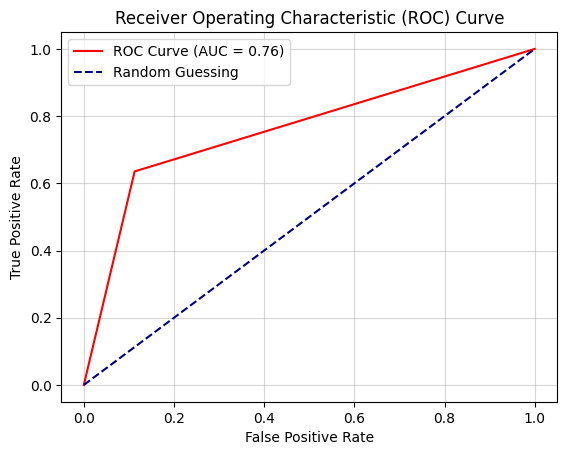

In [21]:
fpr, tpr, _ = roc_curve(all_labels, all_predictions)
auc = roc_auc_score(all_labels, all_predictions)

plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()